In [1]:
import os
import sys
import random
PATH = '/Users/marika/Documents/Github/EDM_Music'
sys.path.append(os.path.join(PATH, 'midi'))

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

import pretty_midi
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

In [ ]:
from pathlib import Path
pth = Path('/Users/marika/Documents/Github/EDM_Music/Lead-Sheet-Dataset'


In [3]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.T
    
    # Binarize the pressed notes 
    piano_roll[piano_roll > 0] = 1  # no need as unique values are 0 and 1
    
    return piano_roll

In [4]:
def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    """
    padding 0 at the beginning of sequence
    
    """
    # We hardcode 88 -- because we will always use only
    # 88 pitches
    
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, :original_piano_roll_length] = piano_roll  # keep 0 padding at begin

    return padded_piano_roll

In [87]:
midi_folders = os.listdir('./Lead-Sheet-Dataset/datasets/pianoroll/a')

In [115]:
ls

Lead-Sheet-Dataset/      dur_list_all_c.npy       octave2_prev_X_te.npy
MIDI_Files/              midi/                    octave2_prev_X_tr.npy
MidiNet-by-pytorch/      music-generation-master/ prev_x.npy
Music2.ipynb             music_edm_new.pth        project helper.ipynb
Nottingham/              music_venv/              requirements.txt
Nottingham.pickle        note_list_all_c.npy      sample.mid
README.md                octave2_X_te.npy
data_x.npy               octave2_X_tr.npy


In [120]:
import shutil
midi_filenames = []
base_dir = 'MIDI_Files/songs/'
for i in midi_folders: 
    if i!='.DS_Store':
        artist_folder = os.listdir('./Lead-Sheet-Dataset/datasets/pianoroll/a/' + str(i) + '/')
        for j in artist_folder: 
            if j!='.DS_Store':
                folder = os.listdir('./Lead-Sheet-Dataset/datasets/pianoroll/a/' + str(i) + '/' + str(j))
                for f in folder:
                    if '.mid' in f and 'nokey' not in f:
                        source = './Lead-Sheet-Dataset/datasets/pianoroll/a/'+ str(i) + '/' + str(j) + "/"+ str(f) 
                        
                        destination = os.path.join(base_dir, str(i) + '_' + str(j) + '_' + f)
                        
                        shutil.copyfile(source, destination)
                    
    
    

In [122]:
midi_folder_path = './MIDI_Files/songs/'
midi_filenames = os.listdir(midi_folder_path)
midi_full_filenames = [os.path.join(midi_folder_path, filename) for filename in midi_filenames]
sequences_lengths = [midi_filename_to_piano_roll(filename).shape[1] for filename in midi_full_filenames]

In [123]:
# stats of sequence lengths 
min(sequences_lengths), max(sequences_lengths), np.median(sequences_lengths), np.mean(sequences_lengths)

(13, 228, 52.0, 64.77083333333333)

In [124]:
# making validation slices of sequence length 50

val_slices=[]

for k in range(len(midi_filenames)):
    piano_roll = midi_filename_to_piano_roll(midi_full_filenames[k])
    
    for i in range(piano_roll.shape[1]):
        if i%50 == 0:
            #print ('here')
            try:
                val_slices.append(piano_roll[:,i:i+51])
            except IndexError:
                pass
    

In [125]:
validation_list = [v for v in val_slices if v.shape[1] == 51]
len(validation_list)

135

In [126]:
class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=50):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = [os.path.join(midi_folder_path, filename) for filename in midi_filenames]
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = [midi_filename_to_piano_roll(filename).shape[1] for filename in self.midi_full_filenames]
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        
        # median length of songs
        if piano_roll.shape[1] > self.longest_sequence_length:
                random_strt_idx = np.random.randint(0, piano_roll.shape[1] -
                                                    self.longest_sequence_length+3, 1) # +3 just to make sure of gaps at the end
                ground_truth_sequence = piano_roll[:, 
                                            random_strt_idx[0] :
                                            random_strt_idx[0]+self.longest_sequence_length]
                input_sequence = piano_roll[:,random_strt_idx[0]-1 :
                                            random_strt_idx[0]+self.longest_sequence_length-1]

        else:
            input_sequence = piano_roll[:,:-1]
            ground_truth_sequence = piano_roll[:, 1:]        
        
        
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length) 
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=0)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([self.longest_sequence_length]) )

In [127]:
class Dataset_validation(data.Dataset):
    
    def __init__(self, val_list, longest_sequence_length=50):
        
        self.val_list = val_list
        self.longest_sequence_length = longest_sequence_length
    
    def __len__(self):
        
        return len(self.val_list)
    
    def __getitem__(self, index): 
        piano_roll = self.val_list[index]
        input_sequence = piano_roll[:,:-1]
        ground_truth_sequence = piano_roll[:, 1:]        
   
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length) 
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=0)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([self.longest_sequence_length]) )

In [128]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1) 
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [131]:
trainset = NotesGenerationDataset('./MIDI_Files/songs', longest_sequence_length=50)

trainset_loader = data.DataLoader(trainset, batch_size=5,
                                              shuffle=True, num_workers=4, drop_last=True)

In [132]:
len(trainset), len(trainset_loader)

(192, 38)

In [133]:
valset = Dataset_validation(validation_list)

valset_loader = data.DataLoader(valset, batch_size=5, shuffle=False, num_workers=4, drop_last=False)

In [134]:
len(valset)

135

In [135]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout = 0.2)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [136]:
model = RNN(input_size=88, hidden_size=512, num_classes=88)

criterion = nn.CrossEntropyLoss()
criterion_val = nn.CrossEntropyLoss(size_average=False)

/Users/marika/Documents/GitHub/EDM_Music/music_venv/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [137]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")
layers = list(model.children())

In [138]:
layers

[Linear(in_features=88, out_features=512, bias=True),
 BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 LSTM(512, 512, num_layers=2, dropout=0.2),
 Linear(in_features=512, out_features=88, bias=True)]

In [139]:
def lrfinder(start, end, model, trainset_loader, epochs=20):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))    
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters,start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1) )

            input_sequences_batch_var = Variable( input_sequences_batch )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

            optimizer.step()
        if epoch_number%5 == 0:
            print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

In [140]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1) )

        input_sequences_batch_var = Variable( input_sequences_batch )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [141]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = model
# lrs, losses = lrfinder(1e-4, 1e-1, rnn, trainset_loader, epochs=30)

In [142]:
def train_model(model, lrs_triangular, epochs_number=10, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, lr=lrs_triangular[0], weight_decay=wd)
    ctr = 0
    
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for batch in trainset_loader:
#             try: 
#                 optimizer.param_groups[0]['lr'] = lrs_triangular[ctr]
#             except IndexError: pass
#             ctr+=1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1) )

            input_sequences_batch_var = Variable( input_sequences_batch )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        current_val_loss = validate(model)
        
#         if epoch_number%5 == 0:
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)   
#         if epoch_number%5 == 0:
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'music_edm_new.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [143]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
best_val_loss = train_model(rnn, [1e-3], epochs_number=11)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 1.0885675220113051
Validation Loss: Epoch: 0 : 0.8233547289299242

Training Loss: Epoch: 1 : 0.31242578300206286
Validation Loss: Epoch: 1 : 0.11325254374802715

Training Loss: Epoch: 2 : 0.09421269968152046
Validation Loss: Epoch: 2 : 0.08307043498132366

Training Loss: Epoch: 3 : 0.07849626576429919
Validation Loss: Epoch: 3 : 0.07791863417705702

Training Loss: Epoch: 4 : 0.07259068128309752
Validation Loss: Epoch: 4 : 0.06964785591921822

Training Loss: Epoch: 5 : 0.07035328300767824
Validation Loss: Epoch: 5 : 0.07159735744489162

Training Loss: Epoch: 6 : 0.06739476764280546
Validation Loss: Epoch: 6 : 0.0733328269675926

Training Loss: Epoch: 7 : 0.06628650524898579
Validation Loss: Epoch: 7 : 0.06987987849688289

Training Loss: Epoch: 8 : 0.06724043190479279
Validation Loss: Epoch: 8 : 0.06818442584207965

Training Loss: Epoch: 9 : 0.06598181699059512
Validation Loss: Epoch: 9 : 0.06772875812158038

Training Loss: Epoch: 10 : 0.0637852230942563
Validat

In [144]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input)
    
    else:
        current_sequence_input = Variable(starting_sequence)
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None    

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).numpy()
    
    return sampled_sequence

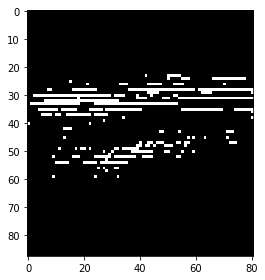

In [145]:
sample = sample_from_piano_rnn(sample_length=80, temperature=0.8).transpose()
io.imshow(sample)

In [146]:
midiwrite('sample.mid', sample.transpose(), dt=0.3)

In [147]:
FileLink('sample.mid')

/Users/marika/Documents/GitHub/EDM_Music/sample.mid